# Automatic Google search of venue images

In [0]:
CITY = 'LANCASTER'

In [2]:
!pip install google_images_download

     |████████████████████████████████| 911kB 9.6MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=bab7af15c4afb0a57f0b22852809ef674f2b8889d55f26fcf22a8d9defdce8e1
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
import pandas as pd
import numpy as np
from google_images_download import google_images_download

In [4]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
from google.colab import files
uploaded = files.upload()

Saving predicthq_export - Lancaster - Ralph Lauren.csv to predicthq_export - Lancaster - Ralph Lauren.csv


In [0]:
events = pd.read_csv("predicthq_export - Lancaster - Ralph Lauren.csv")

In [7]:
events.head(5)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen
0,lLvaYJOkkzk5,The Sweet Sorrows in Concert at Emmaus Road Cafe,"""Sammy and Kylie Horner, collectively known as...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""concert,music""",concerts,America/New_York,US,"""40.033773,-76.250177""",Emmaus Road Cafe,"1886 Lincoln Highway East\r\nLancaster, PA 176...",locality,22,48.0,0.0,active,2016-10-05T03:27:43Z
1,n25dJ6BdMdYR,Rick Kilby-One man Band!,"""Rick Kilby knows how to have fun! Always a BI...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""food,performing-arts""",performing-arts,America/New_York,US,"""40.033267,-76.498226""",Prudhommes' Lost Cajun Kitchen,"50 Lancaster Avenue\r\nColumbia, PA 17512\r\nU...",locality,22,43.0,NaN,active,2016-06-11T00:52:32Z
2,030e6833f057d76d21,Leif Erikson Day,"""Leif Erikson Day honors the first Scandinavia...",2016-10-09T00:00:00Z,2016-10-09T23:59:59Z,NaN,86399,"""holiday,observance""",observances,NaN,US,"""37.09024,-95.712891""",Leif Erikson Day,NaN,country,50,NaN,0.0,active,2015-01-06T12:35:08Z
3,84bd4640e56317fad7,World Post Day,"""World Post Day marks the anniversary of the U...",2016-10-09T00:00:00Z,2016-10-09T23:59:59Z,NaN,86399,"""holiday,observance,observance-united-nations""",observances,NaN,US,"""37.09024,-95.712891""",World Post Day,NaN,country,50,NaN,0.0,active,2015-01-06T12:35:03Z
4,paYvrEAaMVqn,J U FROZENWATER,NaN,2016-10-09T01:00:00Z,2016-10-09T01:00:00Z,NaN,0,"""concert,music""",concerts,America/New_York,US,"""40.041523,-76.309029""",Chameleon Club,"223 N Water St\r\nLancaster, PA 17603\r\nUnite...",locality,50,63.0,NaN,active,2016-09-30T00:29:19Z


In [8]:
events.shape

(5093, 20)

In [9]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5093 entries, 0 to 5092
Data columns (total 20 columns):
id                         5093 non-null object
title                      5093 non-null object
description                2517 non-null object
start                      5093 non-null object
end                        5093 non-null object
predicted_end              139 non-null object
duration                   5093 non-null int64
labels                     5093 non-null object
category                   5093 non-null object
timezone                   4123 non-null object
country                    5093 non-null object
location                   5093 non-null object
venue_name                 4610 non-null object
venue_formatted_address    3664 non-null object
scope                      5093 non-null object
rank                       5093 non-null int64
local_rank                 3665 non-null float64
aviation_rank              3124 non-null float64
state                      509

In [10]:
events['venue_id'] = events.groupby('venue_name').ngroup()
events.head(2)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen,venue_id
0,lLvaYJOkkzk5,The Sweet Sorrows in Concert at Emmaus Road Cafe,"""Sammy and Kylie Horner, collectively known as...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""concert,music""",concerts,America/New_York,US,"""40.033773,-76.250177""",Emmaus Road Cafe,"1886 Lincoln Highway East\r\nLancaster, PA 176...",locality,22,48.0,0.0,active,2016-10-05T03:27:43Z,89
1,n25dJ6BdMdYR,Rick Kilby-One man Band!,"""Rick Kilby knows how to have fun! Always a BI...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""food,performing-arts""",performing-arts,America/New_York,US,"""40.033267,-76.498226""",Prudhommes' Lost Cajun Kitchen,"50 Lancaster Avenue\r\nColumbia, PA 17512\r\nU...",locality,22,43.0,NaN,active,2016-06-11T00:52:32Z,316


In [11]:
events.venue_id.nunique()

475

In [0]:
venue = pd.DataFrame(events[['venue_name', 'venue_id']].drop_duplicates(['venue_id']).dropna())
venue['venue_type'] = ''

In [13]:
len(venue)

474

In [14]:
venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 5025
Data columns (total 3 columns):
venue_name    474 non-null object
venue_id      474 non-null int64
venue_type    474 non-null object
dtypes: int64(1), object(2)
memory usage: 14.8+ KB


In [15]:
venue[venue['venue_name'].str.contains(',')]

,venue_name,venue_id,venue_type
2377,"The Promise Players present, a musical comedy,...",366,
2398,"The Lion, The Witch, and The Wardrobe",364,


In [0]:
# events.to_csv('venue.csv', columns=['venue_name'], index=False)
# Replace ',' with ' ' for search by keywords, which requires separation
# of keywords by ','
venue['new_venue_name'] = venue['venue_name'].str.replace(',', ' ')
venue_name = venue['new_venue_name'].str.cat(sep=',')

In [17]:
venue.head(3)

,venue_name,venue_id,venue_type,new_venue_name
0,Emmaus Road Cafe,89,,Emmaus Road Cafe
1,Prudhommes' Lost Cajun Kitchen,316,,Prudhommes' Lost Cajun Kitchen
2,Leif Erikson Day,246,,Leif Erikson Day


In [18]:
len(venue_name.split(','))

474

In [0]:
import pathlib
import shutil
import os

# Remove directories if exist
image_dir = pathlib.Path('/content/downloads')
if os.path.isdir(image_dir):
  shutil.rmtree(image_dir)

In [20]:
# Class instantiation
response = google_images_download.googleimagesdownload()   

# Create dictionary of arguments
arguments = {"keywords":venue_name, 
            #  "usage_rights":"labeled-for-reuse-with-modifications",
             "limit":1,
             "format":"jpg",
             "color_type":"full-color",
             "type":"photo",
             "size":"medium",
             "silent_mode":True
             }   
paths = response.download(arguments)  

# Places365-CNN for classifying venue images

In [21]:
!pip install Pillow

In [0]:
# https://github.com/CSAILVision/places365/blob/master/run_placesCNN_unified.py
# Demo: http://places2.csail.mit.edu/demo.html
# PlacesCNN to predict the scene category, attribute, and 
# class activation map in a single pass
# by Bolei Zhou, sep 2, 2017

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
# from scipy.misc import imresize as imresize
import cv2
from PIL import Image


def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(imresize(cam_img, size_upsample))
#     return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

In [0]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

In [24]:
all_image_paths = list(image_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths[:5]

['/content/downloads/International Day of Women and Girls in Science/1.Celebrating-International-Day-of-Women-and-Girls-in-Science_OPTIMIZED-870x484.jpg',
 '/content/downloads/International Day to End Obstetric Fistula/1.featured-image-index-sm.jpg',
 '/content/downloads/Kansas Day/1.National-Kansas-Day-March-15-1024x512.jpg',
 '/content/downloads/Wright Brothers Day/1.Wright-Brothers.jpg',
 '/content/downloads/Linden Hall School/1.2_5_FacStaff201819.jpg']

In [25]:
len(all_image_paths)
# Some venue images are unavailable.

405

In [0]:
all_image_venues = list(image_dir.glob('*/*'))
all_image_venues = [str(path.parts[3]) for path in all_image_venues]

In [27]:
all_image_venues[:5]

['International Day of Women and Girls in Science',
 'International Day to End Obstetric Fistula',
 'Kansas Day',
 'Wright Brothers Day',
 'Linden Hall School']

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image(all_image_paths=all_image_paths,
                  all_image_venues=all_image_venues):

  for i in range(5):
    img_path = all_image_paths[i]
    img = mpimg.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
  
    print(all_image_venues[i])

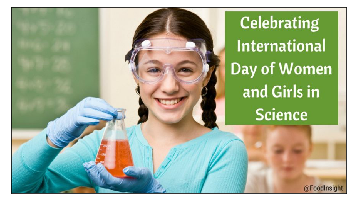

International Day of Women and Girls in Science


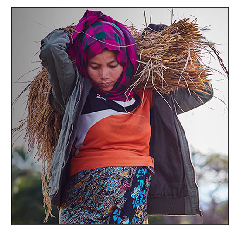

International Day to End Obstetric Fistula


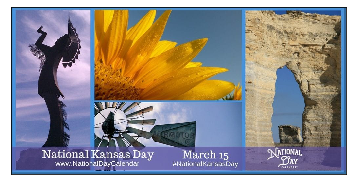

Kansas Day


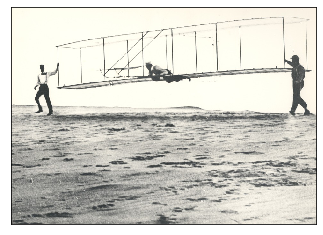

Wright Brothers Day


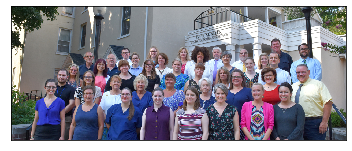

Linden Hall School


In [29]:
display_image()

In [30]:
for i in range(len(all_image_paths)):
  # load the test image
  try:
    img = Image.open(all_image_paths[i])
    input_img = V(tf(img).unsqueeze(0))

    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()

    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
      venue.loc[venue.new_venue_name == all_image_venues[i], ['venue_type']] = 'indoor'
    else:
      venue.loc[venue.new_venue_name == all_image_venues[i], ['venue_type']] = 'outdoor'
      
  except Exception:
    print('Broken image', all_image_paths[i])

Broken image /content/downloads/World Autoimmune / Autoinflammatory Arthritis Day


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Broken image /content/downloads/World Habitat Day/1.world-habitat-day_31012.jpg
Broken image /content/downloads/National POW/MIA Recognition Day
Broken image /content/downloads/Tu Bishvat/Tu B'Shevat
Broken image /content/downloads/Shrove Tuesday/Mardi Gras
Broken image /content/downloads/Chanukah/Hanukkah (first day)
Broken image /content/downloads/Diwali/Deepavali


In [0]:
# Fill empty strings with nan
venue = venue.replace(r'^\s*$', np.nan, regex=True)

In [32]:
venue.head(10)

,venue_name,venue_id,venue_type,new_venue_name
0,Emmaus Road Cafe,89,NaN,Emmaus Road Cafe
1,Prudhommes' Lost Cajun Kitchen,316,indoor,Prudhommes' Lost Cajun Kitchen
2,Leif Erikson Day,246,indoor,Leif Erikson Day
3,World Post Day,442,outdoor,World Post Day
4,Chameleon Club,36,indoor,Chameleon Club
7,American Music Theatre,11,indoor,American Music Theatre
9,Columbus Day,51,indoor,Columbus Day
11,World Mental Health Day,432,indoor,World Mental Health Day
12,Dussehra,72,indoor,Dussehra
13,Bube's Brewery,32,indoor,Bube's Brewery


In [33]:
venue[venue['venue_type'].isnull()]

,venue_name,venue_id,venue_type,new_venue_name
0,Emmaus Road Cafe,89,NaN,Emmaus Road Cafe
27,Steinman Park,350,NaN,Steinman Park
42,Sweetest Day,353,NaN,Sweetest Day
81,Last Day of Sukkot,244,NaN,Last Day of Sukkot
86,Shmini Atzeret,337,NaN,Shmini Atzeret
...,...,...,...,...
3268,LCBC Church,215,NaN,LCBC Church
3527,The Ware Center,374,NaN,The Ware Center
3867,Piercing Word Presents: Christmas Through The ...,311,NaN,Piercing Word Presents: Christmas Through The ...
4029,Melhorn Manor,257,NaN,Melhorn Manor


# Some NLPs to fill NA's / reclassify

## Top 150 tagging

In [0]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# Flatten into a list
tokens = venue.apply(lambda x: nltk.word_tokenize(x['venue_name']), axis=1).sum()
tags = nltk.pos_tag(tokens)

In [0]:
nouns = [token[0] for token in tags if token[1] == 'NNP']
frequency = nltk.FreqDist(nouns)
top_150 = frequency.most_common(150)

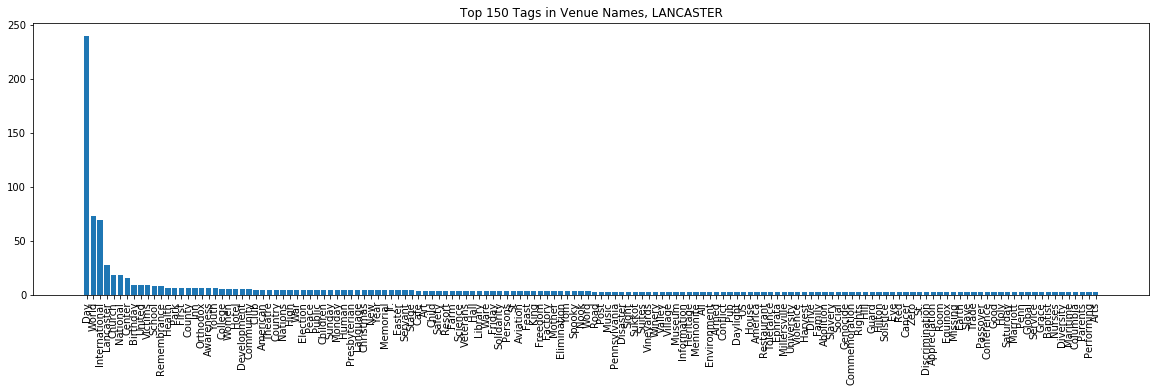

In [36]:
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_150)), [val[1] for val in top_150], align='center')
plt.xticks(range(len(top_150)), [val[0] for val in top_150])
plt.xticks(rotation=90)
plt.title('Top 150 Tags in Venue Names, ' + CITY)
plt.savefig('Top 150 Tags in Venue Names, ' + CITY + '.jpg')
plt.show()

In [37]:
[val[0] for val in top_150]

['Day',
 'World',
 'International',
 'Lancaster',
 'Church',
 'National',
 'Center',
 'Birthday',
 'United',
 'Victims',
 'School',
 'Remembrance',
 'Health',
 'Park',
 'First',
 'County',
 'Inn',
 'Orthodox',
 'Awareness',
 'Youth',
 'College',
 'Women',
 'Hotel',
 'Development',
 'Community',
 'Club',
 'American',
 'Theatre',
 'Country',
 'Nations',
 'High',
 'War',
 'Election',
 'Peace',
 'Public',
 'Children',
 'Sunday',
 'Monday',
 'Human',
 'Presbyterian',
 'Language',
 'Christmas',
 'New',
 'Year',
 'Memorial',
 'Jr.',
 'Easter',
 'Servant',
 'Stage',
 'Cafe',
 'Art',
 'Child',
 'Safety',
 'Resort',
 'Farm',
 'Science',
 'Veterans',
 'Hall',
 'Library',
 'Ware',
 'Friday',
 'Solidarity',
 'Persons',
 'St',
 'Aviation',
 'Feast',
 'King',
 'Freedom',
 'Factory',
 'Mother',
 'Elimination',
 'Yom',
 'Spooky',
 'Nook',
 'Word',
 'Road',
 'Post',
 'Music',
 'Pennsylvania',
 'Disaster',
 'Sight',
 'Sukkot',
 'Suites',
 'Vineyards',
 'Winery',
 'Valley',
 'Village',
 'Museum',
 'Inform

In [0]:
indoor_word_list = ['Church', 'Center', 'School', 'Inn', 'College', 'Hotel', \
                    'Club', 'Theatre', 'Cafe', 'Resort', 'Hall', 'Library', \
                    'Factory', 'Suites', 'Winery', 'Museum', 'Pub', 'House', \
                    'Restaurant', 'University', 'Hilton', 'Room', 'Conference', \
                    'Marriott']
outdoor_word_list = ['Day', 'Park', 'Farm', 'Vineyards',]
# 'Commemoration'

In [0]:
import inflect
# Obtain the plurals for the words
engine = inflect.engine() # case-sensitive
indoor_word_list_pl = [engine.plural(w.lower()) for w in indoor_word_list]
outdoor_word_list_pl = [engine.plural(w.lower()) for w in outdoor_word_list]

In [0]:
# Case-insensitive
indoor_list = [s.lower() for s in indoor_word_list + indoor_word_list_pl]
outdoor_list = [s.lower() for s in outdoor_word_list + outdoor_word_list_pl]

## Reclassification

In [0]:
def compare_venue_type(df, indoor_list=indoor_list, outdoor_list=outdoor_list):
  # Compute count of substrings in indoor_list/outdoor_list
  # e.g., 'Spa Ravella at Hilton Lake Las Vegas' will have 
  # indoor_cnt = 2 and outdoor_cnt = 1, thus will be classified as 'indoor'
  indoor_cnt = sum(map(lambda x: x.lower() in indoor_list, df['new_venue_name'].split(' ')))
  outdoor_cnt = sum(map(lambda x: x.lower() in outdoor_list, df['new_venue_name'].split(' ')))
  
  return 'indoor' if indoor_cnt >= outdoor_cnt else 'outdoor'

In [0]:
venue['venue_type'] = venue.apply(compare_venue_type, axis=1)

In [43]:
venue.head(10)

,venue_name,venue_id,venue_type,new_venue_name
0,Emmaus Road Cafe,89,indoor,Emmaus Road Cafe
1,Prudhommes' Lost Cajun Kitchen,316,indoor,Prudhommes' Lost Cajun Kitchen
2,Leif Erikson Day,246,outdoor,Leif Erikson Day
3,World Post Day,442,outdoor,World Post Day
4,Chameleon Club,36,indoor,Chameleon Club
7,American Music Theatre,11,indoor,American Music Theatre
9,Columbus Day,51,outdoor,Columbus Day
11,World Mental Health Day,432,outdoor,World Mental Health Day
12,Dussehra,72,indoor,Dussehra
13,Bube's Brewery,32,indoor,Bube's Brewery


- What are left?

In [44]:
venue[venue['venue_type'].isnull()]

,venue_name,venue_id,venue_type,new_venue_name


In [45]:
venue.venue_type.value_counts()

outdoor    242
indoor     232
Name: venue_type, dtype: int64

- Most of the events have the type `indoor`. We will set it as default for the rest.

In [0]:
venue.loc[venue['venue_type'].isnull(),  ['venue_type']] = 'indoor'

# Output

In [46]:
venue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474 entries, 0 to 5025
Data columns (total 4 columns):
venue_name        474 non-null object
venue_id          474 non-null int64
venue_type        474 non-null object
new_venue_name    474 non-null object
dtypes: int64(1), object(3)
memory usage: 18.5+ KB


In [0]:
venue.to_csv('events_' + CITY + '_venues.csv', index=False)

In [0]:
events_new = pd.merge(events, venue[['venue_id', 'venue_type']], 
                      on='venue_id',
                      how='left').drop('venue_id', 1)

In [49]:
events_new.shape

(5093, 21)

In [50]:
events_new.head(3)

,id,title,description,start,end,predicted_end,duration,labels,category,timezone,country,location,venue_name,venue_formatted_address,scope,rank,local_rank,aviation_rank,state,first_seen,venue_type
0,lLvaYJOkkzk5,The Sweet Sorrows in Concert at Emmaus Road Cafe,"""Sammy and Kylie Horner, collectively known as...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""concert,music""",concerts,America/New_York,US,"""40.033773,-76.250177""",Emmaus Road Cafe,"1886 Lincoln Highway East\r\nLancaster, PA 176...",locality,22,48.0,0.0,active,2016-10-05T03:27:43Z,indoor
1,n25dJ6BdMdYR,Rick Kilby-One man Band!,"""Rick Kilby knows how to have fun! Always a BI...",2016-10-08T23:00:00Z,2016-10-09T02:00:00Z,NaN,10800,"""food,performing-arts""",performing-arts,America/New_York,US,"""40.033267,-76.498226""",Prudhommes' Lost Cajun Kitchen,"50 Lancaster Avenue\r\nColumbia, PA 17512\r\nU...",locality,22,43.0,NaN,active,2016-06-11T00:52:32Z,indoor
2,030e6833f057d76d21,Leif Erikson Day,"""Leif Erikson Day honors the first Scandinavia...",2016-10-09T00:00:00Z,2016-10-09T23:59:59Z,NaN,86399,"""holiday,observance""",observances,NaN,US,"""37.09024,-95.712891""",Leif Erikson Day,NaN,country,50,NaN,0.0,active,2015-01-06T12:35:08Z,outdoor


In [51]:
events_new.category.unique()

array(['concerts', 'performing-arts', 'observances', 'public-holidays',
       'severe-weather', 'community', 'expos', 'conferences',
       'airport-delays', 'festivals', 'daylight-savings', 'politics',
       'disasters', 'school-holidays', 'sports'], dtype=object)

In [0]:
events_new.to_csv('events_' + CITY + '.csv', index=False)

In [0]:
from google.colab import files

In [0]:
files.download('Top 150 Tags in Venue Names, ' + CITY + '.jpg')

In [0]:
files.download('events_' + CITY + '_venues.csv')

In [0]:
files.download('events_' + CITY + '.csv') 

In [0]:
output_zip = 'venue_images_' + CITY + '.zip'

In [58]:
!zip -r $output_zip $image_dir

  adding: content/downloads/ (stored 0%)
  adding: content/downloads/International Day of Women and Girls in Science/ (stored 0%)
  adding: content/downloads/International Day of Women and Girls in Science/1.Celebrating-International-Day-of-Women-and-Girls-in-Science_OPTIMIZED-870x484.jpg (deflated 1%)
  adding: content/downloads/International Day to End Obstetric Fistula/ (stored 0%)
  adding: content/downloads/International Day to End Obstetric Fistula/1.featured-image-index-sm.jpg (deflated 9%)
  adding: content/downloads/Kansas Day/ (stored 0%)
  adding: content/downloads/Kansas Day/1.National-Kansas-Day-March-15-1024x512.jpg (deflated 3%)
  adding: content/downloads/Wright Brothers Day/ (stored 0%)
  adding: content/downloads/Wright Brothers Day/1.Wright-Brothers.jpg (deflated 0%)
  adding: content/downloads/Linden Hall School/ (stored 0%)
  adding: content/downloads/Linden Hall School/1.2_5_FacStaff201819.jpg (deflated 2%)
  adding: content/downloads/International Migrants Day/ (

In [0]:
files.download(output_zip)